# How to apply optimal QAOA transpilation with a StagedPassManager

This tutorial shows how applying domain-specific transpilation strategies allows to reduce circuit depth and 2-qubit gate count on qaoa circuits.

References:

[1] Sack, S. H., & Egger, D. J. (2023). Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation. arXiv preprint arXiv:2307.14427.

[2] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870. 

## Problem setting

We'll start our workflow with a graph that represents a hypothetical max-cut problem, for example:

In [704]:
from networkx import barabasi_albert_graph, draw
graph = barabasi_albert_graph(n=5, m=3, seed=42)

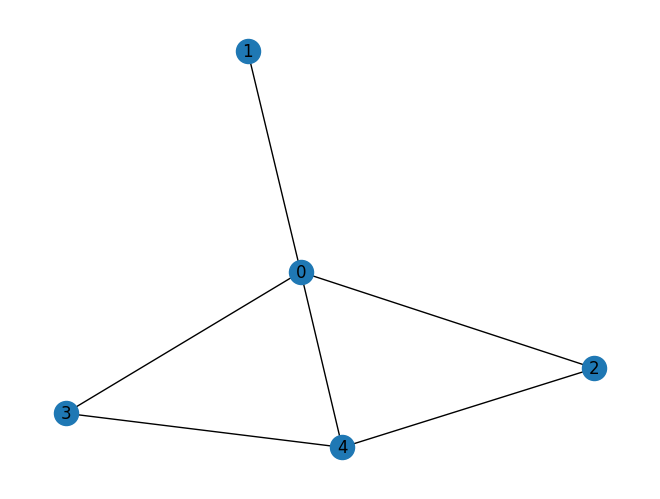

In [705]:
draw(graph, with_labels=True)

The graph above corresponds to the following operator.

In [706]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [707]:
# import json

# graph_file = "data/graph_2layers_0seed.json"
# data = json.load(open(graph_file, "r"))

# local_correlators = data["paulis"]
# print(local_correlators)
# cost_operator = SparsePauliOp.from_list(local_correlators)

This operator maps to a 10 qubit QAOA circuit:

In [708]:
num_qubits = cost_operator.num_qubits
print(num_qubits)

5


And we'll fix the number of QAOA layers to 3 for both workflows:

In [709]:
qaoa_layers = 1

We can design a fake backend with the same basis gates and connectivity as "ibm_torino" but smaller number of qubits that will allow us to perform a statevector simulation:

In [710]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
print(cmap.size())
backend = GenericBackendV2(num_qubits = 5, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)
# backend = GenericBackendV2(num_qubits = cmap.size(), coupling_map = cmap, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)

19


Now, let's look at a naive workflow using exclusively transpilation defaults:

## Naive QAOA Workflow

Build QAOA circuit/ansatz:

In [711]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import qaoa_ansatz
from qiskit.circuit import ParameterVector

# Use off-the-shelf qiskit qaoa_ansatz
qaoa_circuit = qaoa_ansatz(cost_operator, reps = qaoa_layers)
# qaoa_circuit.measure_all()

Let's inspect the default pass manager for optimization level 3:

In [712]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

The pass contains the following stages:

In [713]:
print(naive_pm.expanded_stages)

('pre_init', 'init', 'post_init', 'pre_layout', 'layout', 'post_layout', 'pre_routing', 'routing', 'post_routing', 'pre_translation', 'translation', 'post_translation', 'pre_optimization', 'optimization', 'post_optimization', 'pre_scheduling', 'scheduling', 'post_scheduling')


In [714]:
# naive_pm.draw()

And the following passes per stage:

In [715]:
print("init")
for task in naive_pm.init._tasks:
    print(task)

print("----")
print("layout")
for task in naive_pm.layout._tasks:
    print(task)

print("----")
print("routing")
for task in naive_pm.routing._tasks:
    print(task)

print("----")
print("translation")
for task in naive_pm.translation._tasks:
    print(task)

print("----")
print("optimization")
for task in naive_pm.optimization._tasks:
    print(task)

print("----")
print("scheduling")
for task in naive_pm.scheduling._tasks:
    print(task)

init
[<qiskit.transpiler.passes.optimization.remove_diagonal_gates_before_measure.RemoveDiagonalGatesBeforeMeasure object at 0x374c8bb90>, <qiskit.transpiler.passes.optimization.remove_identity_equiv.RemoveIdentityEquivalent object at 0x374ed1310>, <qiskit.transpiler.passes.optimization.inverse_cancellation.InverseCancellation object at 0x374ed1750>, <qiskit.transpiler.passes.optimization.contract_idle_wires_in_control_flow.ContractIdleWiresInControlFlow object at 0x374ed0990>]
----
layout
----
routing
----
translation
[<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis object at 0x374ec6190>, <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x3720814d0>, <qiskit.transpiler.passes.basis.basis_translator.BasisTranslator object at 0x374ec6590>]
----
optimization
[<qiskit.transpiler.passes.analysis.depth.Depth object at 0x374f4f150>, <qiskit.transpiler.passes.analysis.size.Size object at 0x374f4db50>, <qiskit.transpiler.passes.utils

Let's use it to transpile the circuit:

In [716]:
def callback_func(**kwargs):
    pass_ = kwargs['pass_']
    print(pass_)

In [717]:
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_circuit)
t1 = time.time()

In [718]:
print(f"transpilation time: {t1 - t0} (s)")

transpilation time: 0.0059049129486083984 (s)


In [719]:
naively_transpiled_qaoa.count_ops()

OrderedDict([('rz', 34), ('sx', 23), ('cz', 12)])

In [720]:
naively_transpiled_qaoa.depth()

51

Let's look at a domain-specific transpialation workflow and see how the transpilation time, total number of 2q gates and circuit depth compares to the default pipeline.

## Optimal QAOA Transpilation Workflow

The optimal QAOA workflow consists on the following steps:

1. We start off by only building the cost layer of the QAOA ansatz (this is the one that contains 2q gates)
2. We transpile the cost layer applying specific swap strategies as per [1,2]
3. We then build the QAOA circuit by alternating layers of transpiled cost + mixer
4. We translate the circuit to the hardware native gates and route it to the optimal qubit layout through backend evaluation as per [2]
   
**What's interesting about this workflow is that we can embed it fully in a custom staged pass manager.** For this, we will use our own **"QAOAConstructionPass"** for step 3 of the workflow, and use passes already available in Qiskit to perform steps 2 and 4. The custom **"QAOAConstructionPass"** is available in this best practices repository.

### 1. Build cost layer

The construction of the cost layer relies on the `qaoa_ansatz` method from `qiskit.circuit.library`. However, to get only a cost layer without initial state or mixer we call the `get_cost_layer` method from `qopt_best_practices.transpilation.cost_layer` which takes care of removing the initial state and mixer. These will come back into play later.

In [721]:
from qopt_best_practices.transpilation.cost_layer import get_cost_layer

In [722]:
from __future__ import annotations
from collections.abc import Sequence

import typing
import warnings
import itertools
import numpy as np

from qiskit.circuit.library.pauli_evolution import PauliEvolutionGate
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.parametervector import ParameterVector
from qiskit.circuit import QuantumRegister
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.synthesis.evolution.product_formula import real_or_fail

from qiskit._accelerate.circuit_library import pauli_evolution

from qiskit.circuit.library.n_local import NLocal

if typing.TYPE_CHECKING:
    from qiskit.synthesis.evolution import EvolutionSynthesis
    
from qiskit.circuit import annotation, QuantumCircuit

class CostLayerAnnotation(annotation.Annotation):
    namespace = "qaoa.cost_layer"

class MixerAnnotation(annotation.Annotation):
    namespace = "qaoa.mixer"

class InitStateAnnotation(annotation.Annotation):
    namespace = "qaoa.init_state"

# circ = QuantumCircuit(4)
# circ.h(range(4))
# with circ.box(annotations=(CostLayerAnnotation(),)):
#     circ.rx(pi, 0)
#     circ.cx(0, 3)
# circ.measure_all()


def annotated_evolved_operator_ansatz(
    operators: BaseOperator | Sequence[BaseOperator],
    reps: int = 1,
    evolution: EvolutionSynthesis | None = None,
    insert_barriers: bool = False,
    name: str = "EvolvedOps",
    parameter_prefix: str | Sequence[str] = "t",
    remove_identities: bool = True,
    flatten: bool | None = None,
    annotations: Sequence[annotation.Annotation]=None,
) -> QuantumCircuit:
    r"""Construct an ansatz out of operator evolutions.

    For a set of operators :math:`[O_1, ..., O_J]` and :math:`R` repetitions (``reps``), this circuit
    is defined as

    .. math::

        \prod_{r=1}^{R} \left( \prod_{j=J}^1 e^{-i\theta_{j, r} O_j} \right)

    where the exponentials :math:`exp(-i\theta O_j)` are expanded using the product formula
    specified by ``evolution``.

    Examples:

    .. plot::
        :alt: Circuit diagram output by the previous code.
        :include-source:

        from qiskit.circuit.library import evolved_operator_ansatz
        from qiskit.quantum_info import Pauli

        ops = [Pauli("ZZI"), Pauli("IZZ"), Pauli("IXI")]
        ansatz = evolved_operator_ansatz(ops, reps=3, insert_barriers=True)
        ansatz.draw("mpl")

    Args:
        operators: The operators to evolve. Can be a single operator or a sequence thereof.
        reps: The number of times to repeat the evolved operators.
        evolution: A specification of which evolution synthesis to use for the
            :class:`.PauliEvolutionGate`. Defaults to first order Trotterization. Note, that
            operators of type :class:`.Operator` are evolved using the :class:`.HamiltonianGate`,
            as there are no Hamiltonian terms to expand in Trotterization.
        insert_barriers: Whether to insert barriers in between each evolution.
        name: The name of the circuit.
        parameter_prefix: Set the names of the circuit parameters. If a string, the same prefix
            will be used for each parameters. Can also be a list to specify a prefix per
            operator.
        remove_identities: If ``True``, ignore identity operators (note that we do not check
            :class:`.Operator` inputs). This will also remove parameters associated with identities.
        flatten: If ``True``, a flat circuit is returned instead of nesting it inside multiple
            layers of gate objects. Setting this to ``False`` is significantly less performant,
            especially for parameter binding, but can be desirable for a cleaner visualization.
    """
    if reps < 0:
        raise ValueError("reps must be a non-negative integer.")

    if isinstance(operators, BaseOperator):
        operators = [operators]
    elif len(operators) == 0:
        return QuantumCircuit()

    num_operators = len(operators)
    if not isinstance(parameter_prefix, str):
        if num_operators != len(parameter_prefix):
            raise ValueError(
                f"Mismatching number of operators ({len(operators)}) and parameter_prefix "
                f"({len(parameter_prefix)})."
            )

    num_qubits = operators[0].num_qubits
    if remove_identities:
        operators, parameter_prefix = _remove_identities(operators, parameter_prefix)

    if any(op.num_qubits != num_qubits for op in operators):
        raise ValueError("Inconsistent numbers of qubits in the operators.")

    # get the total number of parameters
    if isinstance(parameter_prefix, str):
        parameters = ParameterVector(parameter_prefix, reps * num_operators)
        param_iter = iter(parameters)
    else:
        # this creates the parameter vectors per operator, e.g.
        #    [[a0, a1, a2, ...], [b0, b1, b2, ...], [c0, c1, c2, ...]]
        # and turns them into an iterator
        #    a0 -> b0 -> c0 -> a1 -> b1 -> c1 -> a2 -> ...
        per_operator = [ParameterVector(prefix, reps).params for prefix in parameter_prefix]
        param_iter = itertools.chain.from_iterable(zip(*per_operator))

    # # fast, Rust-path
    # if (
    #     flatten is not False  # captures None and True
    #     and evolution is None
    #     and all(isinstance(op, SparsePauliOp) for op in operators)
    # ):
    #     sparse_labels = [op.to_sparse_list() for op in operators]
    #     expanded_paulis = []
    #     for _ in range(reps):
    #         for term in sparse_labels:
    #             param = next(param_iter)
    #             expanded_paulis += [
    #                 (pauli, indices, 2 * real_or_fail(coeff) * param)
    #                 for pauli, indices, coeff in term
    #             ]

    #     data = pauli_evolution(num_qubits, expanded_paulis, insert_barriers, False)
    #     circuit = QuantumCircuit._from_circuit_data(data, legacy_qubits=True)
    #     circuit.name = name

    #     return circuit

    # slower, Python-path
    if evolution is None:
        from qiskit.synthesis.evolution import LieTrotter

        evolution = LieTrotter(insert_barriers=insert_barriers)

    circuit = QuantumCircuit(num_qubits, name=name)

    # pylint: disable=cyclic-import
    from qiskit.circuit.library.hamiltonian_gate import HamiltonianGate

    for rep in range(reps):
        for i, op in enumerate(operators):
            if isinstance(op, Operator):
                gate = HamiltonianGate(op, next(param_iter))
                if flatten:
                    warnings.warn(
                        "Cannot flatten the evolution of an Operator, flatten is set to "
                        "False for this operator."
                    )
                flatten_operator = False

            elif isinstance(op, BaseOperator):
                gate = PauliEvolutionGate(op, next(param_iter), synthesis=evolution)
                flatten_operator = flatten is True or flatten is None
            else:
                raise ValueError(f"Unsupported operator type: {type(op)}")

            if flatten_operator:
                if annotations:
                    with circuit.box(annotations=(annotations[i],)):
                        circuit.compose(gate.definition, inplace=True)
                else:
                    circuit.compose(gate.definition, inplace=True)

            else:
                if annotations:
                    with circuit.box(annotations=(annotations[i],)):
                        circuit.append(gate, circuit.qubits)
                else:
                    circuit.append(gate, circuit.qubits)

            if insert_barriers and (rep < reps - 1 or i < num_operators - 1):
                circuit.barrier()

    return circuit


def _is_pauli_identity(operator):
    if isinstance(operator, SparsePauliOp):
        if len(operator.paulis) == 1:
            operator = operator.paulis[0]  # check if the single Pauli is identity below
        else:
            return False
    if isinstance(operator, Pauli):
        return not np.any(np.logical_or(operator.x, operator.z))
    return False


def _remove_identities(operators, prefixes):
    identity_ops = {index for index, op in enumerate(operators) if _is_pauli_identity(op)}

    if len(identity_ops) == 0:
        return operators, prefixes

    cleaned_ops = [op for i, op in enumerate(operators) if i not in identity_ops]
    cleaned_prefix = [prefix for i, prefix in enumerate(prefixes) if i not in identity_ops]

    return cleaned_ops, cleaned_prefix

In [723]:
from qiskit.quantum_info.operators.base_operator import BaseOperator

def annotated_qaoa_ansatz(
    cost_operator: BaseOperator,
    reps: int = 1,
    initial_state: QuantumCircuit | None = None,
    mixer_operator: BaseOperator | None = None,
    insert_barriers: bool = False,
    name: str = "QAOA",
    flatten: bool = True,
) -> QuantumCircuit:
    r"""A generalized QAOA quantum circuit with a support of custom initial states and mixers.

    Examples:

        To define the QAOA ansatz we require a cost Hamiltonian, encoding the classical
        optimization problem:

        .. plot::
            :alt: Circuit diagram output by the previous code.
            :include-source:

            from qiskit.quantum_info import SparsePauliOp
            from qiskit.circuit.library import qaoa_ansatz

            cost_operator = SparsePauliOp(["ZZII", "IIZZ", "ZIIZ"])
            ansatz = qaoa_ansatz(cost_operator, reps=3, insert_barriers=True)
            ansatz.draw("mpl")

    Args:
        cost_operator: The operator representing the cost of the optimization problem, denoted as
            :math:`U(C, \gamma)` in [1].
        reps: The integer determining the depth of the circuit, called :math:`p` in [1].
        initial_state: An optional initial state to use, which defaults to a layer of
            Hadamard gates preparing the :math:`|+\rangle^{\otimes n}` state.
            If a custom mixer is chosen, this circuit should be set to prepare its ground state,
            to appropriately fulfill the annealing conditions.
        mixer_operator: An optional custom mixer, which defaults to global Pauli-:math:`X`
            rotations. This is denoted as :math:`U(B, \beta)` in [1]. If this is set,
            the ``initial_state`` might also require modification.
        insert_barriers: Whether to insert barriers in-between the cost and mixer operators.
        name: The name of the circuit.
        flatten: If ``True``, a flat circuit is returned instead of nesting it inside multiple
            layers of gate objects. Setting this to ``False`` is significantly less performant,
            especially for parameter binding, but can be desirable for a cleaner visualization.

    References:

        [1]: Farhi et al., A Quantum Approximate Optimization Algorithm.
            `arXiv:1411.4028 <https://arxiv.org/pdf/1411.4028>`_
    """
    num_qubits = cost_operator.num_qubits

    if initial_state is None:
        ansatz = QuantumCircuit(num_qubits)
        with ansatz.box(annotations=(InitStateAnnotation(),)):
            ansatz.h(range(num_qubits))
    else:
        ansatz = QuantumCircuit(num_qubits)
        with ansatz.box(annotations=(InitStateAnnotation(),)):
            ansatz.compose(initial_state, inplace=True)
            # ansatz.append(initial_state, range(num_qubits))

    if mixer_operator is None:
        mixer_operator = SparsePauliOp.from_sparse_list(
            [("X", [i], 1) for i in range(num_qubits)], num_qubits
        )

    parameter_prefix = ["γ", "β"]

    annotations = [CostLayerAnnotation(), MixerAnnotation()]
    return ansatz.compose(
        annotated_evolved_operator_ansatz(
            [cost_operator, mixer_operator],
            reps=reps,
            insert_barriers=insert_barriers,
            parameter_prefix=parameter_prefix,
            name=name,
            flatten=flatten,
            annotations=annotations
        ),
        copy=False,
    )


In [724]:
initial_state = QuantumCircuit(cost_operator.num_qubits)
initial_state.x(range(cost_operator.num_qubits))
initial_state.h(range(cost_operator.num_qubits))

qaoa_circuit = annotated_qaoa_ansatz(cost_operator, reps = qaoa_layers, initial_state=initial_state)
qaoa_circuit.measure_all()

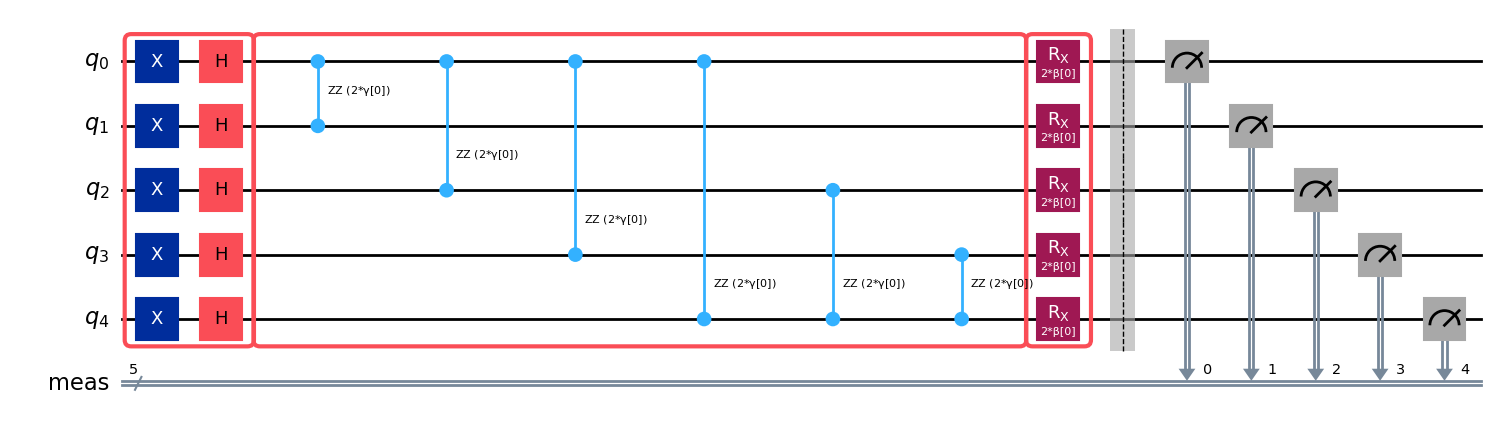

In [725]:
qaoa_circuit.draw('mpl', fold=-1)

In [726]:
cost_layer = get_cost_layer(cost_operator)

# qaoa_ansatz will have a left-over beta parameter which we set to zero.
print(cost_layer.parameters)

ParameterView([ParameterVectorElement(γ[0])])


If we look inside the block we'll see a succession of $R_{ZZ}$ gates that represent the problem hamiltonian:

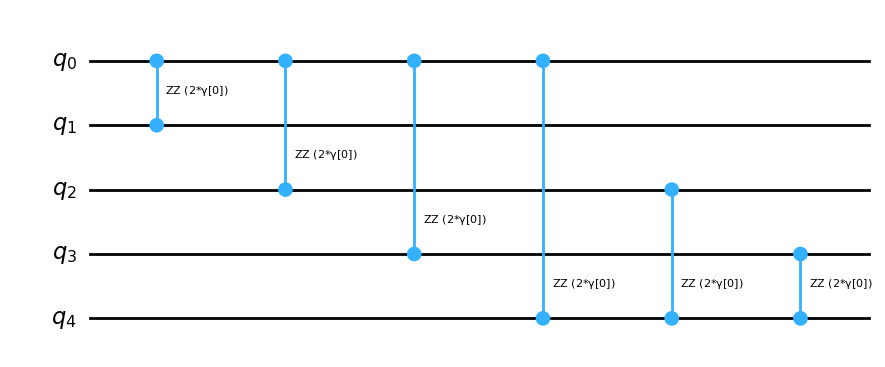

In [727]:
cost_layer.draw("mpl", fold=-1)

### 2. Design pass manager for cost layer transpilation

The cost layer transpilation stage will apply the swap strategies from [1,2] to optimally route the cost layer circuit into the connectivity of our backend. This collection of passes will insert swap gates to fit the circuit to the chip connectivity in a way that will allow to maximally cancel CNOT gates and reduce the total circuit depth.

Note that we are routing the circuit into a `line`, which proves to be optimal in most QAOA cases. To make sure that the line fits into our chip, we use the `BackendEvaluator` utility before committing to the swap strategy:

In [728]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)
print(path, fidelity)

[0, 4, 3, 2, 1] 0.9943841408444584


The collection of passes defined below will be embedded into the "pre_init" stage of our `StagedPassManager`.

In [729]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    HighLevelSynthesis,
    InverseCancellation
)

from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    Commuting2qGateRouter,
)

from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate

from qopt_best_practices.transpilation.prepare_cost_layer import PrepareCostLayer
from qopt_best_practices.transpilation.swap_cancellation_pass import SwapToFinalMapping

We need to signal to the transpiler that the gates in the QAOA cost layer all commute with each other. This is done by wrapping them in a special `Commuting2qBlock` circuit instruction. This instruction is picked-up by the transpiler pass that implements the swap network.

In [730]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
    [
        PrepareCostLayer(),
        Commuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)

In [731]:
fake_init = PassManager(
    [
        PrepareCostLayer()
    ]
)
out = fake_init.run(cost_layer)
out.h(range(cost_layer.num_qubits))
out.rz(Parameter("a"), range(cost_layer.num_qubits))
fake_init = PassManager(
    [
        Commuting2qGateRouter(swap_strategy, edge_coloring),
    ]
)
out2 = fake_init.run(out)
out2.draw()

┌───┐  ┌───────┐  »
q_0 -> 0 ─■────────────X───────────────────────X──────┤ H ├──┤ Rz(a) ├──»
          │ZZ(2*γ[0])  │                       │      ├───┤  ├───────┤  »
q_1 -> 1 ─■────────────X──■────────────X───────X──────┤ H ├──┤ Rz(a) ├──»
                          │ZZ(2*γ[0])  │              └───┘  └─┬───┬─┘  »
q_2 -> 2 ──────────────X──■────────────X──■─────────────X──────┤ H ├────»
                       │                  │ZZ(2*γ[0])   │      └───┘    »
q_3 -> 3 ─■────────────X──■────────────X──■─────────────X───■───────────»
          │ZZ(2*γ[0])     │ZZ(2*γ[0])  │                    │ZZ(2*γ[0]) »
q_4 -> 4 ─■───────────────■────────────X────────────────────■───────────»
                                                                        »
«                           
«q_0 -> 0 ──────────────────
«                           
«q_1 -> 1 ──────────────────
«         ┌───────┐         
«q_2 -> 2 ┤ Rz(a) ├─────────
«         └─┬───┬─┘┌───────┐
«q_3 -> 3 ──┤ H ├──┤ Rz(a) ├
«           ├───┤  ├───────┤
«q_4 -> 4 ──┤ H ├──┤ Rz(a) ├
«           └───┘  └───────┘

We can run this pass manager independently to confirm that it performs the desired transformations:

OrderedDict([('rzz', 6)])


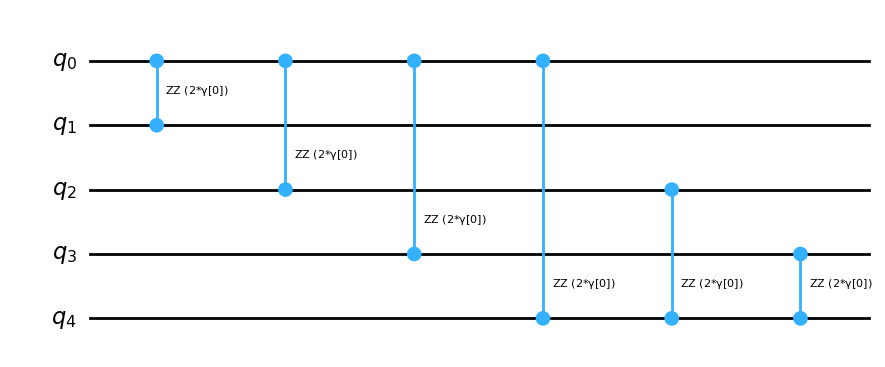

In [732]:
# Before:
print(cost_layer.count_ops())
cost_layer.draw("mpl", fold=-1)

In [733]:
tmp = pre_init.run(cost_layer)

OrderedDict([('cx', 19), ('rz', 6)])


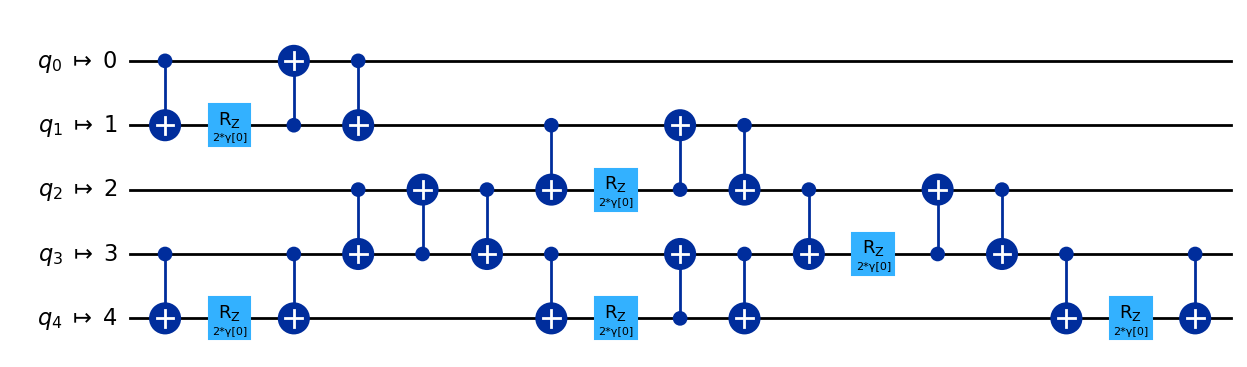

In [734]:
# After:
print(tmp.count_ops())
tmp.draw('mpl', fold=-1)

### 3. Build QAOA Ansatz

We now need to design a way to embed our optimized cost layer circuit into the QAOA ansatz, which consists of alternating layers of cost and mixer operators following an inital state. We can do it as part of a custom transformation pass that can be initialized with the desired cost layer, mixer layer, number of total layers and number of qubits. This pass will be placed at the "init" stage, after the pre_init pass has routed the cost layer. The pass can be found in the `transpilation` folder of the best practices.

In [735]:
from qopt_best_practices.transpilation.qaoa_construction_pass import QAOAConstructionPass

Once again, let's check that this custom pass runs and builds a QAOA circuit with 3 layers:

In [736]:
init = PassManager([QAOAConstructionPass(num_layers=qaoa_layers)])

layout not found, assigining trivial layout


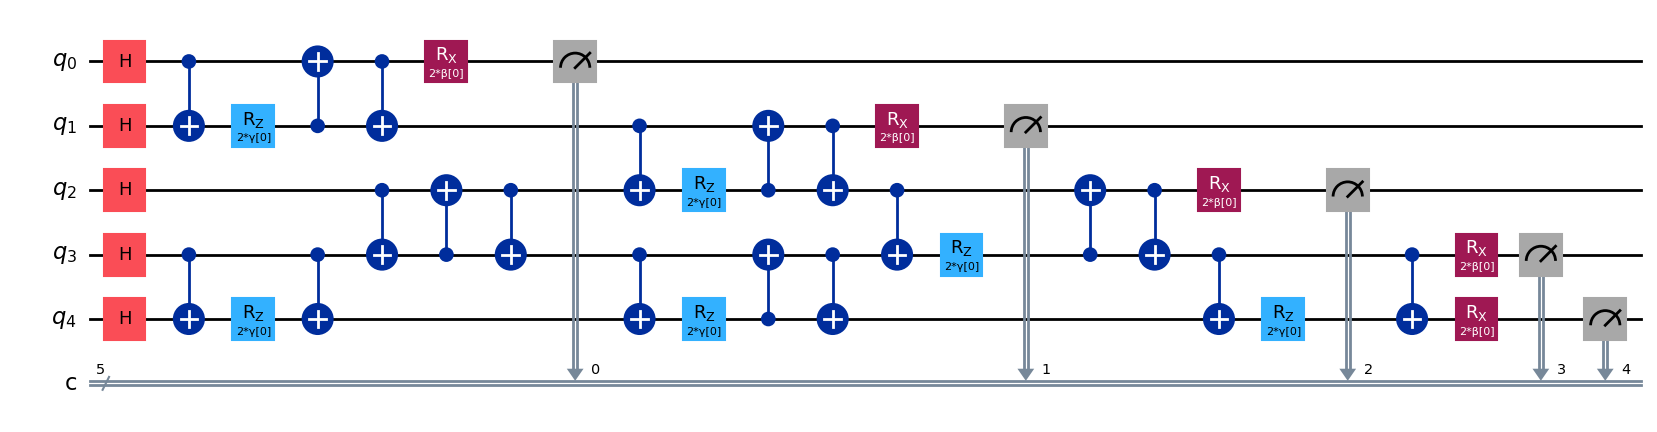

In [737]:
tmp_out = init.run(tmp)
tmp_out.count_ops()
tmp_out.draw('mpl', fold=-1)

### 4. Complete the pipeline

Now that we can build our optimized QAOA ansatz, we need to fill out the remaining stages of the pipeline. We can use as a reference the output of the preset pass manager and just replace the init, pre-init and post-init stages with our custom pass managers. We will have to define a "post_init" step that takes care of the basis translation part to match the expected output in the default pipeline.

In [738]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(path, cost_layer.qregs[0])

In [739]:
# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names, min_qubits=3),
        BasisTranslator(_sel, target_basis=backend.operation_names, min_qubits=3),
    ]
)

In [740]:
staged_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
staged_pm.pre_init = pre_init
staged_pm.init = init
staged_pm.post_init = post_init
# staged_pm.routing = None

In [741]:
print("pre_init")
for task in staged_pm.pre_init._tasks:
    print(task)
    
print("----")
print("init")
for task in staged_pm.init._tasks:
    print(task)

print("----")
print("post_init")
for task in staged_pm.post_init._tasks:
    print(task)
    
print("----")
print("layout")
for task in staged_pm.layout._tasks:
    print(task)

print("----")
print("optimization")
for task in staged_pm.optimization._tasks:
    print(task)

print("----")
print("routing")
for task in staged_pm.routing._tasks:
    print(task)

pre_init
[<qopt_best_practices.transpilation.prepare_cost_layer.PrepareCostLayer object at 0x374f939d0>, <qiskit.transpiler.passes.routing.commuting_2q_gate_routing.commuting_2q_gate_router.Commuting2qGateRouter object at 0x374eb14d0>, <qopt_best_practices.transpilation.swap_cancellation_pass.SwapToFinalMapping object at 0x3751e4e50>, <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x375112010>, <qiskit.transpiler.passes.optimization.inverse_cancellation.InverseCancellation object at 0x3751e4390>]
----
init
----
post_init
[<qiskit.transpiler.passes.basis.unroll_custom_definitions.UnrollCustomDefinitions object at 0x374ec6150>, <qiskit.transpiler.passes.basis.basis_translator.BasisTranslator object at 0x375618b10>]
----
layout
----
optimization
[<qiskit.transpiler.passes.analysis.depth.Depth object at 0x3755f6910>, <qiskit.transpiler.passes.analysis.size.Size object at 0x3755f7450>, <qiskit.transpiler.passes.utils.minimum_point.MinimumPoint object a

### 5. Run the StagedPassManager

In [742]:
t0_opt = time.time()
optimally_transpiled_qaoa = staged_pm.run(cost_layer)
t1_opt = time.time()

## Comparison between naive and optimal

In [743]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 12
2q gate count for optimal circuit = 19


In [744]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 12
2q depth for optimal circuit = 13


In [745]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 51
total depth for optimal circuit = 49


In [746]:
time_naive = t1 - t0
time_optimal = (t1_opt - t0_opt)

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 0.0059049129486083984 (s)
total time for optimal transpilation = 0.001950979232788086 (s)


In [747]:
# optimally_transpiled_qaoa.draw(fold=-1)

In [748]:
# naively_transpiled_qaoa.draw(fold=-1)

## Stripping down the pipeline

In [749]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
    CommutativeCancellation,
)

# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names),
        BasisTranslator(_sel, target_basis=backend.operation_names),
    ]
)

# The layout step applies the previously computed layout and enlarges the circuit 
# with ancilla qubits to have the same number of physical qubits as the target
layout = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend.target),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# The optimization step performs additional gate cancellations
optimization = PassManager(
    [
      CommutativeCancellation(target=backend.target)
    ]
)

from qiskit.transpiler import StagedPassManager
other_staged_pm = StagedPassManager(stages=["init", "layout", 'optimization'], pre_init=pre_init, init=init, post_init=post_init, layout=layout, optimization=optimization)

In [750]:
t0_opt = time.time()
optimally_transpiled_qaoa = other_staged_pm.run(cost_layer)
t1_opt = time.time()

In [751]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 12
2q gate count for optimal circuit = 19


In [752]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 12
2q depth for optimal circuit = 13


In [753]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 51
total depth for optimal circuit = 57


In [754]:
time_naive = t1 - t0
time_optimal = (t1_opt - t0_opt)

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 0.0059049129486083984 (s)
total time for optimal transpilation = 0.0017638206481933594 (s)


In [755]:
optimally_transpiled_qaoa.parameters
naively_transpiled_qaoa.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

In [ ]:
naively_transpiled_qaoa = naively_transpiled_qaoa.assign_parameters([0.1 for i in naively_transpiled_qaoa.parameters])
optimally_transpiled_qaoa = optimally_transpiled_qaoa.assign_parameters([0.1 for i in optimally_transpiled_qaoa.parameters])

new_circuit = QuantumCircuit(optimally_transpiled_qaoa.num_qubits)
for instr, qargs, cargs in optimally_transpiled_qaoa.data:
    if instr.name != "measure":
        new_circuit.append(instr, qargs, cargs)

a = Operator(new_circuit)
b = Operator(naively_transpiled_qaoa)

print(a==b)

ValueError: Mismatching number of values and parameters. For partial binding please pass a mapping of {parameter: value} pairs.